# radial basis function neural networks(RBFNNs)

In [1]:
%matplotlib inline 
from IPython.core.display import display

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd
from sympy import *
import matplotlib.figure
init_printing()
#from math import *
from interval import interval
from interval import imath as im
import sys
from pprint import pprint

In [2]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
import numpy as np
import pandas as pd

## $NN(x_1, x_2) = exp(-4(x_1 - 1)^2  -  6(x_2 - 0.5)^2) + exp(-7(x_1+1.5)^2 - 9(x_2+1)^2)$
where $x_1 \in [-2,2], x_2 \in [-2,2]$

### グラフの可視化

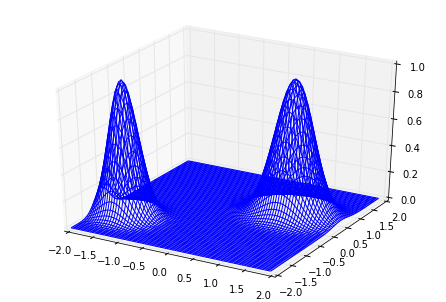

In [3]:
def activate_func(x):
    """
    params:
        x = np.array([x_1, x_2])
    """
    return np.exp(-4*((x[0]-1)**2) - 6*((x[1]-0.5)**2)) + \
        np.exp(-7*((x[0]+1.5)**2) - 9*((x[1]+1)**2))
    
# x = np.arange(-1.6, -1.35, 0.004) 
# y = np.arange(-1.16, -0.9, 0.004) 

x = np.arange(-2, 2, 0.05) 
y = np.arange(-2, 2, 0.05) 

X, Y = np.meshgrid(x, y)
Z = np.apply_along_axis(activate_func, 0, np.array([X.flatten(), Y.flatten()])).reshape(X.shape)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_wireframe(X,Y,Z) 
plt.show()

### Krawczyk method

In [4]:
!touch find_all_solution.out
from ivmat import (
    ivmat, 
    fmat, 
    Krawczyk
)

In [5]:
x_1, x_2, x_3 = var("x_1 x_2 x_3")
f_x_1 = symbols("f_x_1", cls=Function)
f_x_2 = symbols("f_x_2", cls=Function)
nn = exp(-4*(x_1-1)**2 - 6*(x_2-0.5)**2) + exp(-7*(x_1+1.5)**2 - 9*(x_2+1)**2)
func_eval = lambda func: (lambda x_1, x_2, exp=im.exp: eval(str(func)))
f = fmat([[func_eval(nn)]])
f_grad_symbol = [[nn.diff(x_1)],[nn.diff(x_2)]]
f_grad = fmat([[func_eval(nn.diff(x_1))], [func_eval(nn.diff(x_2))]])
hes = hessian(nn, (x_1,x_2))
f_grad_grad = fmat([[None for i in range(hes.shape[1])] for j in range(hes.shape[0])])
for i in range(2):
    for j in range(2):
        f_grad_grad[i][j] = func_eval(hes[i,j])

# x_1= interval[-1.6, -1.45]
# x_2 = interval[-0.9,-1.2]
# X = ivmat([[x_1],[x_2]])
# kra = Krawczyk(f_grad,f_grad_grad,X)

#### 自動微分 

----nn-----



----nn_grad----


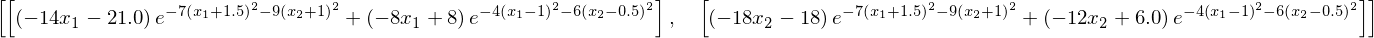


-----nn_hessian-----


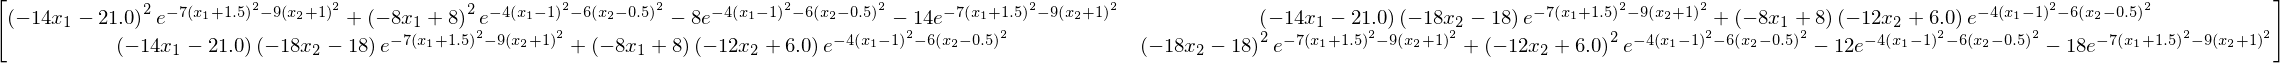

In [6]:
print '----' + 'nn' + '-----'
display(nn)
print
print '----' + 'nn_grad' + '----'
display(f_grad_symbol)
print
print '-----' + 'nn_hessian' + '-----'
display(hes)
print
# print '-----' + 'X' + '-------'
# pprint(X)
# print

#### 全解探索

In [7]:
%run ivmat

In [8]:
# x_1 = interval[11.239995, 11.239999]
# x_2 = interval[7.8599, 7.86]

In [9]:
x_1 = interval[-5,12]
x_2 = interval[-2,9]

x_1 = interval[-2, -0.6]
x_2 = interval[-2, 0.3]
X = ivmat([[x_1],[x_2]])


kra = Krawczyk(f_grad,f_grad_grad,X)

cnt_max = 2000
max_width = 1e-4
boxes, S_num_list, T_num_list, U_num_list, animation_box = kra.find_all_solution(trace=False, cnt_max=cnt_max, max_width=max_width)
print '#####'*10
pprint(boxes)

Loop end. cnt:88, len(S):0, len(T):1, len(U):0

88
---------- 最終的なS[:10] -----------
[]
---------- 最終的なU[:10] -----------
[]
---------- 最終的なT -----------
[[[interval([-1.5162692805863025, -1.4859326798040835])],
  [interval([-1.0147010717127243, -0.9855421018281532])]]]
##################################################
[[[interval([-1.5000000000000002, -1.4999999999999996])],
  [interval([-1.0000000000001656, -0.9999999999998371])]]]


T_num


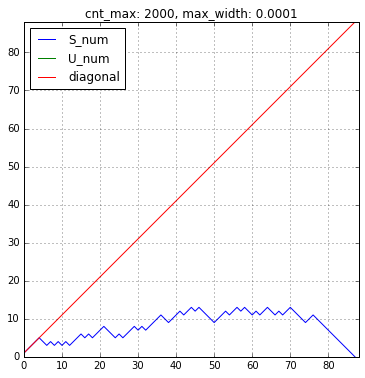

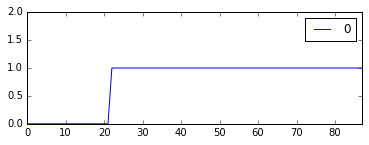

In [10]:
title = 'cnt_max: {}, max_width: {}'.format(cnt_max, max_width)
df = pd.DataFrame([S_num_list, U_num_list, range(1, len(S_num_list)+1)]).T
df.columns = ['S_num', 'U_num', 'diagonal']
df.plot(grid=True, title=title, figsize=(6,6), xlim=(0, len(S_num_list)), ylim=(0, len(S_num_list)))
print 'T_num'
pd.DataFrame(T_num_list).plot(ylim=(0,T_num_list[-1]+1), figsize=(6,2))

## 探索の可視化

In [11]:
pprint(animation_box[:5])
_NO_SOLUTIONS_FLAG = '_NO_SOLUTIONS_FLAG'
_EXACT_1_SOLUTION_FLAG = '_EXACT_1_SOLUTION_FLAG'
_MULTI_SOLUTIONS_FLAG = '_MULTI_SOLUTIONS_FLAG'  # less than 1 solution
_UNCLEAR_SOLUTION_FLAG = '_UNCLEAR_SOLUTION_FLAG'

flag_color_map ={_NO_SOLUTIONS_FLAG: "#888888", 
 _UNCLEAR_SOLUTION_FLAG: "#eeeeff",
_EXACT_1_SOLUTION_FLAG: "#ff9999"}


[([[interval([-2.0, -0.6])], [interval([-2.0, 0.3])]],
  '_UNCLEAR_SOLUTION_FLAG'),
 ([[interval([-2.0, -0.6])], [interval([-2.0, -0.85])]],
  '_UNCLEAR_SOLUTION_FLAG'),
 ([[interval([-2.0, -0.6])], [interval([-0.85, 0.3])]],
  '_UNCLEAR_SOLUTION_FLAG'),
 ([[interval([-2.0, -0.6])], [interval([-2.0, -0.85])]],
  '_UNCLEAR_SOLUTION_FLAG'),
 ([[interval([-2.0, -1.3])], [interval([-2.0, -0.85])]],
  '_UNCLEAR_SOLUTION_FLAG')]


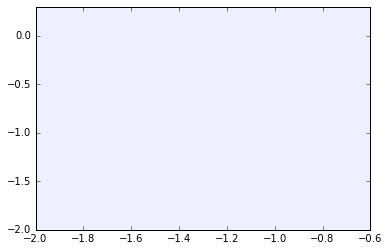

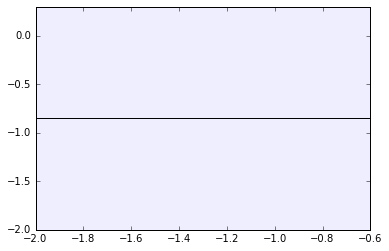

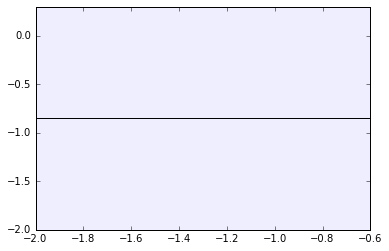

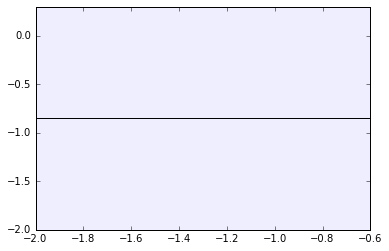

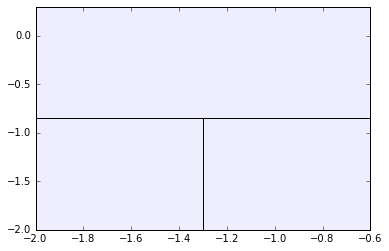

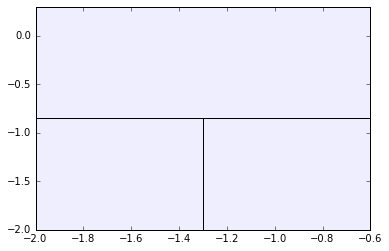

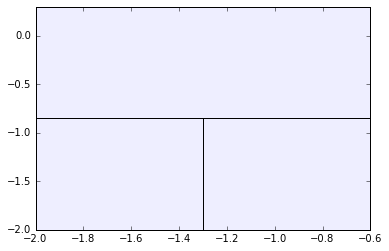

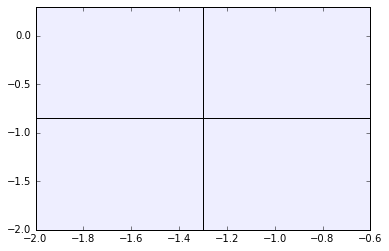

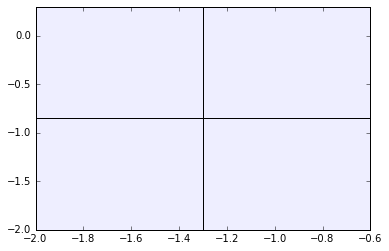

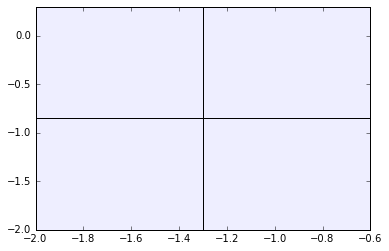

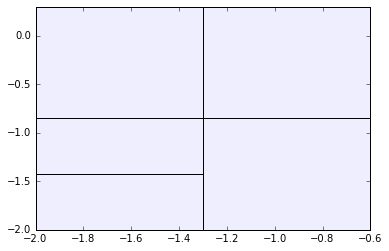

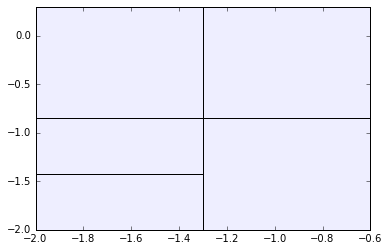

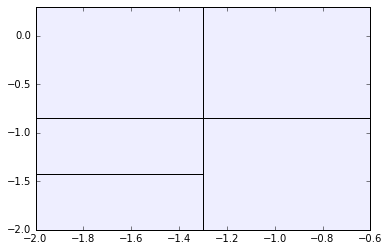

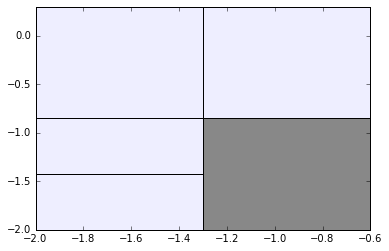

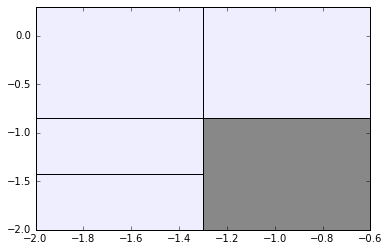

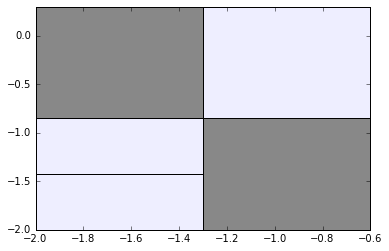

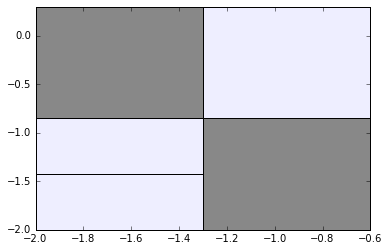

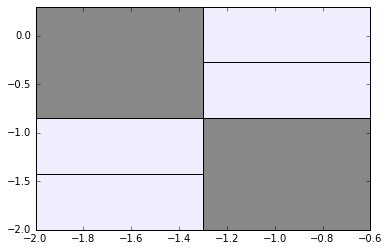

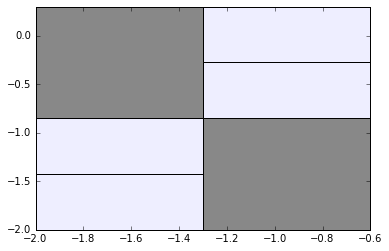

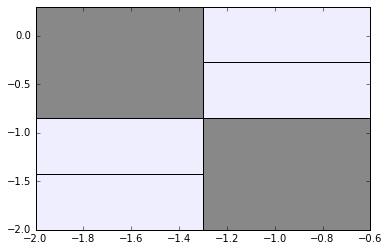

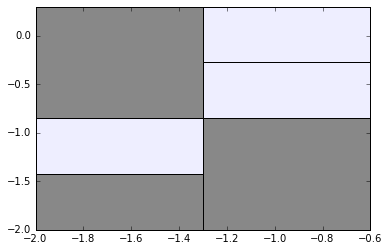

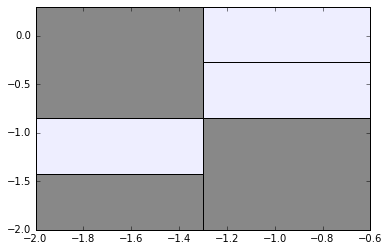

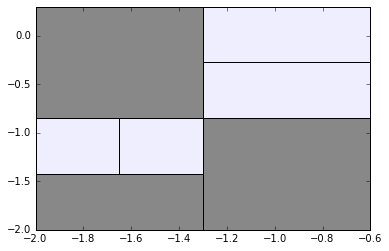

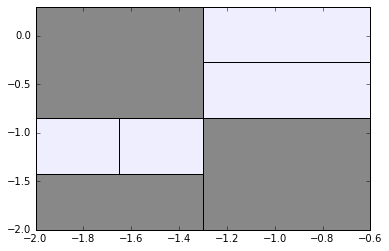

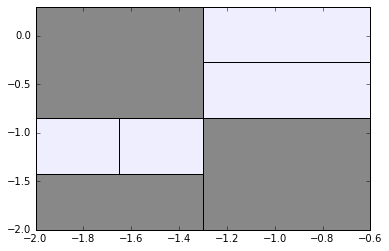

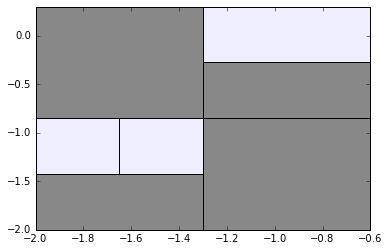

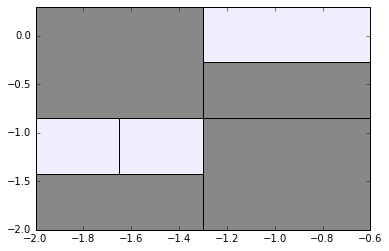

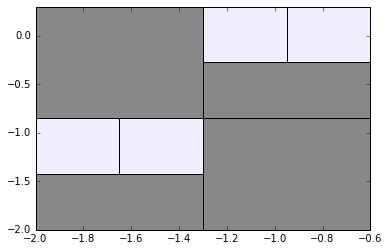

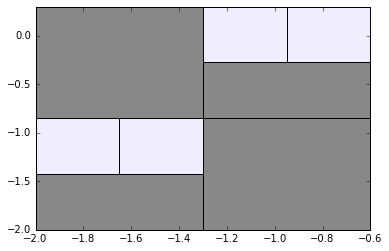

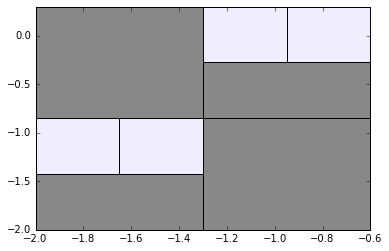

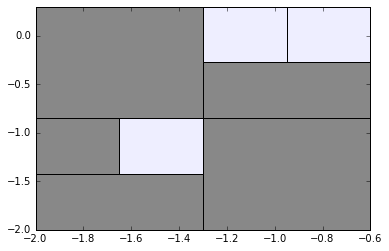

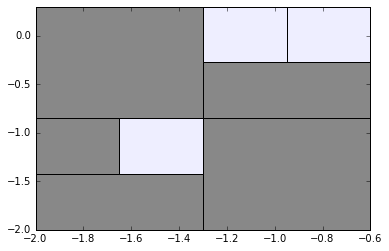

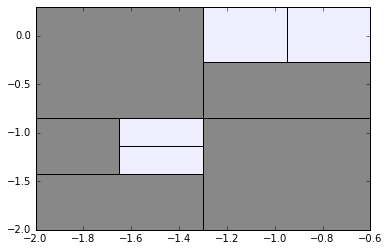

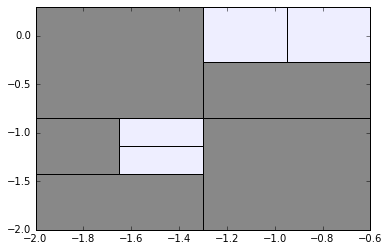

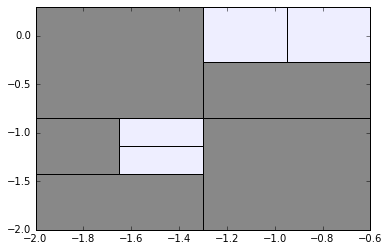

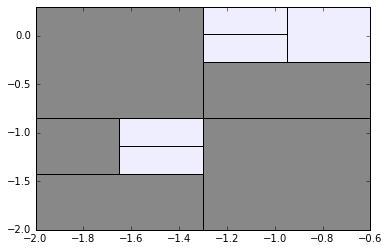

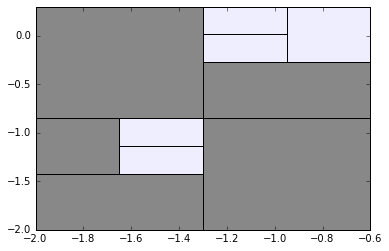

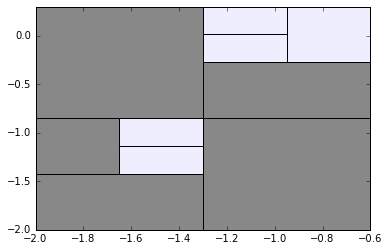

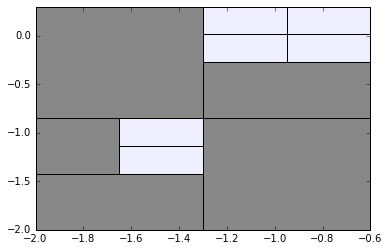

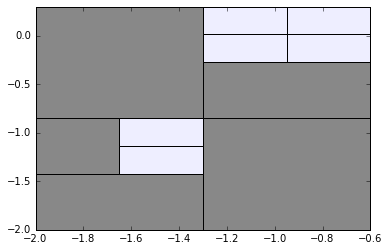

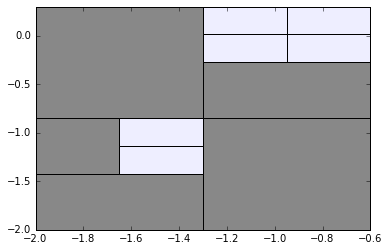

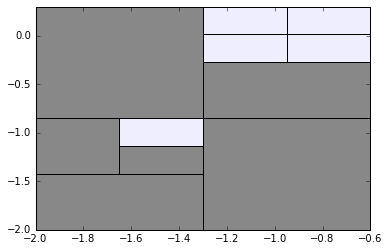

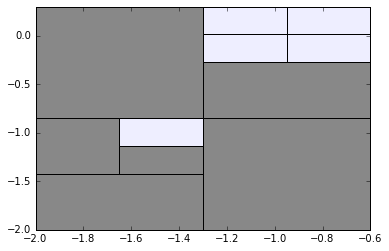

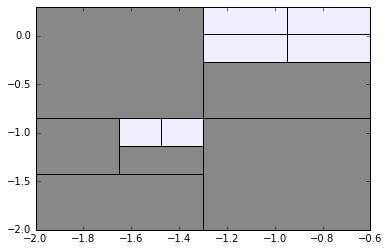

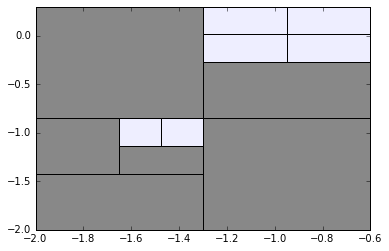

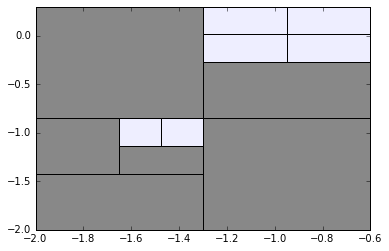

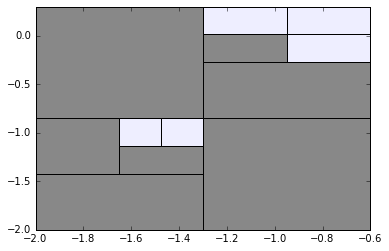

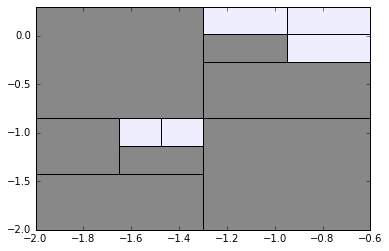

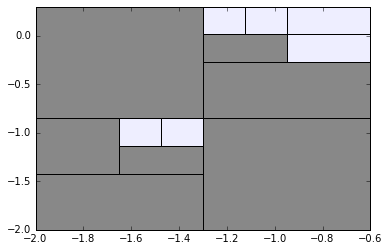

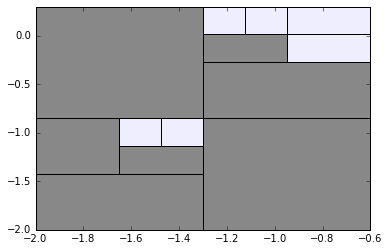

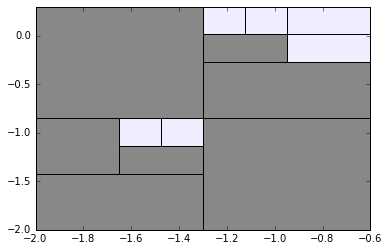

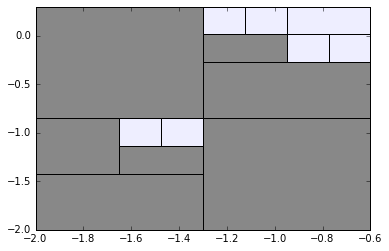

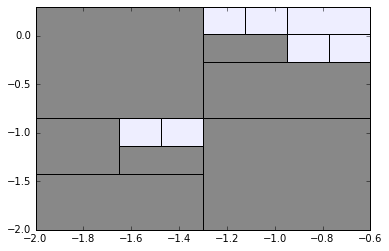

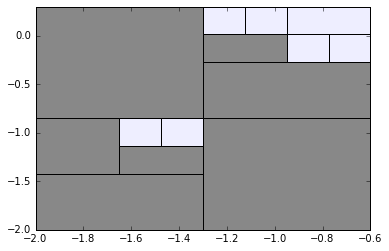

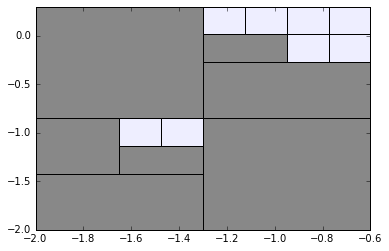

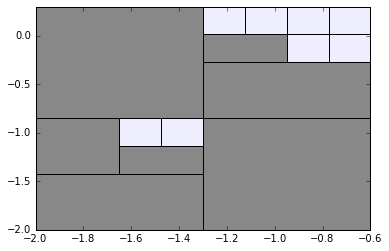

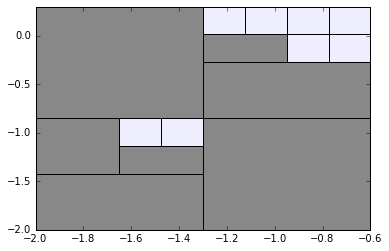

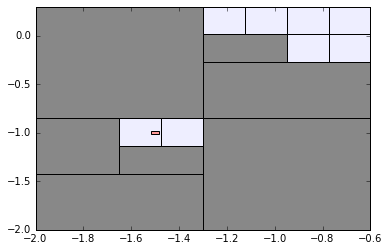

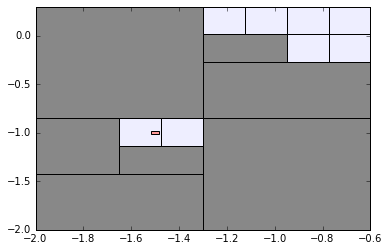

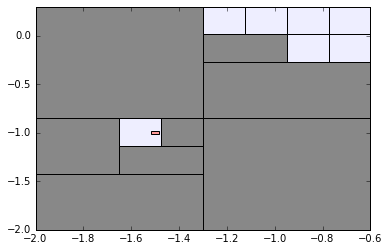

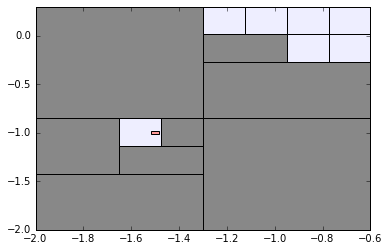

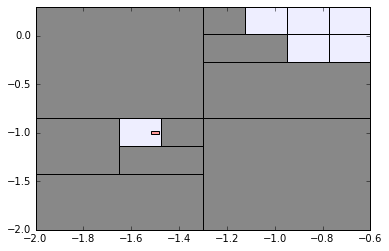

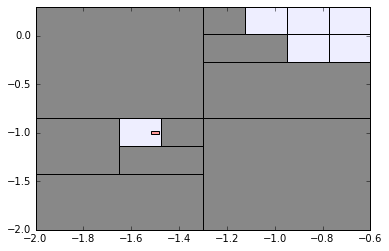

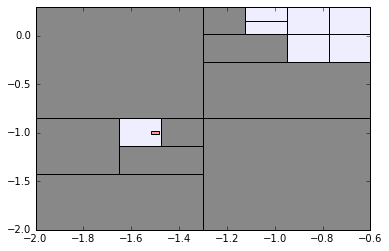

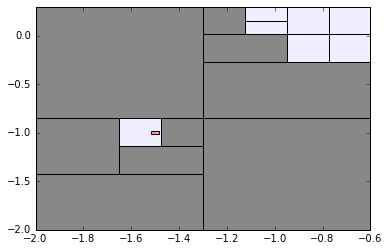

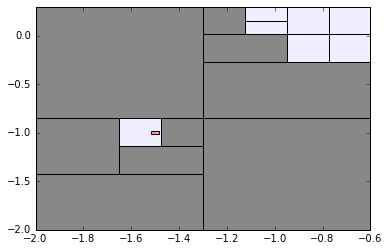

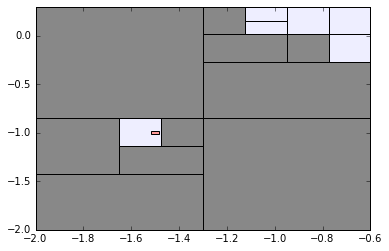

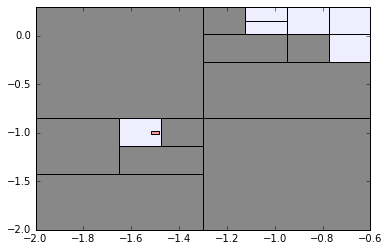

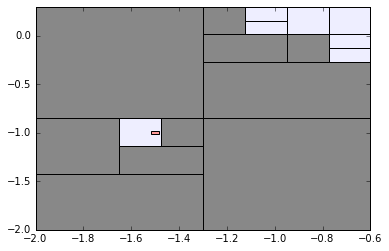

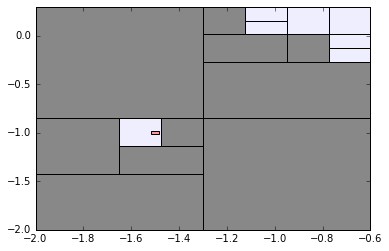

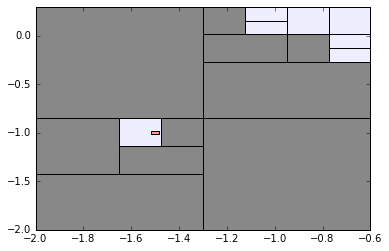

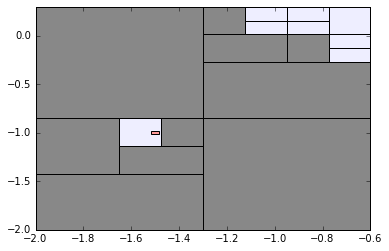

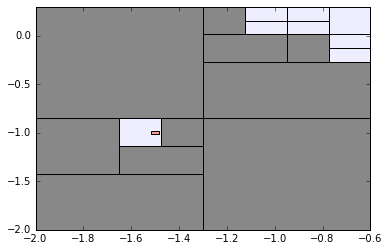

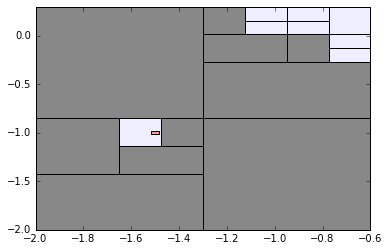

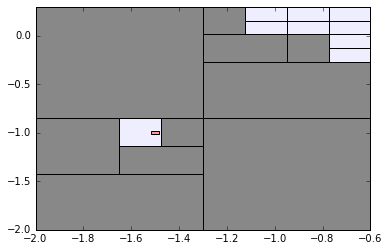

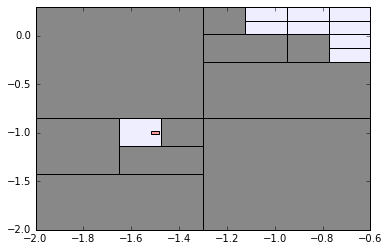

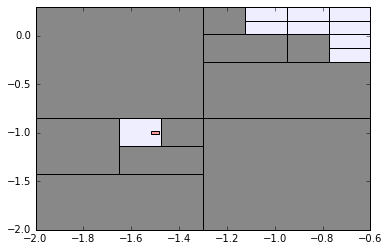

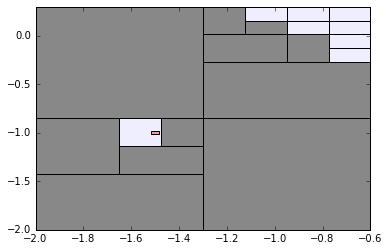

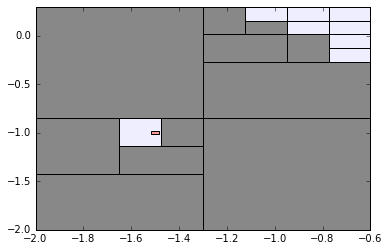

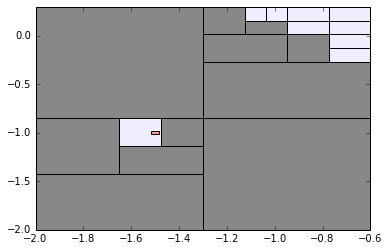

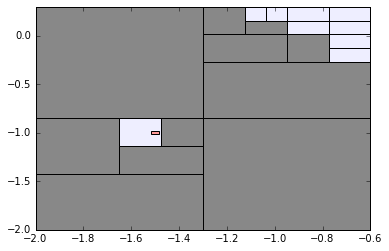

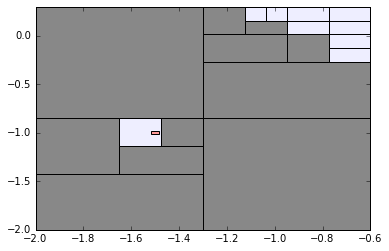

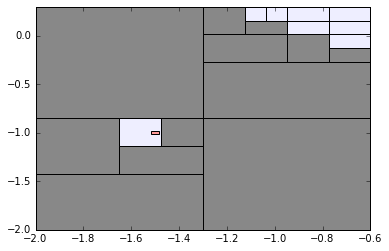

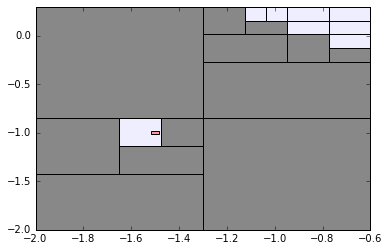

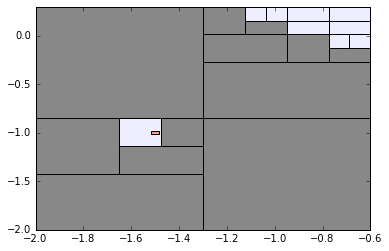

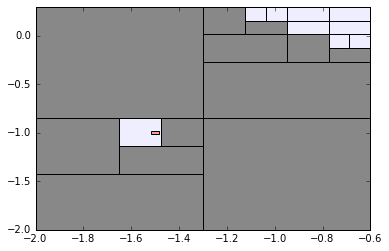

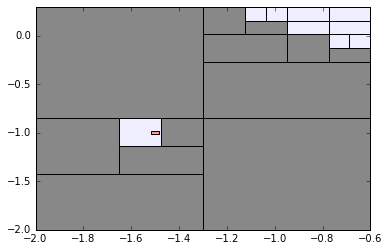

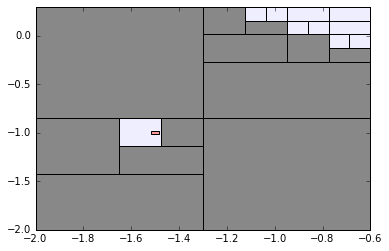

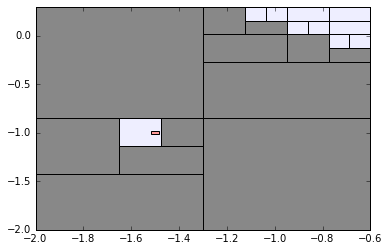

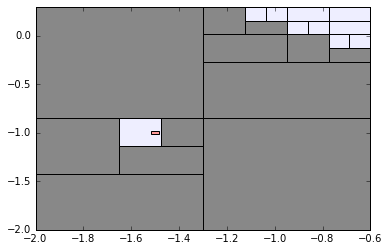

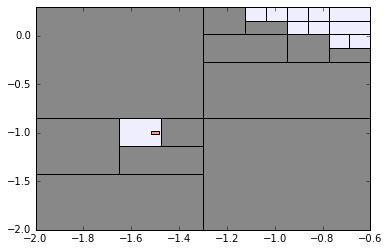

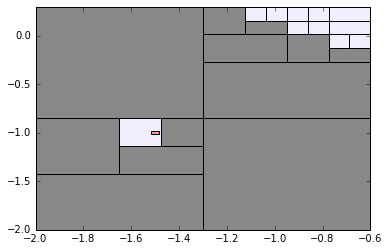

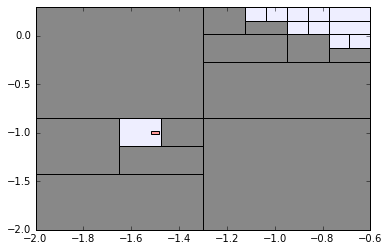

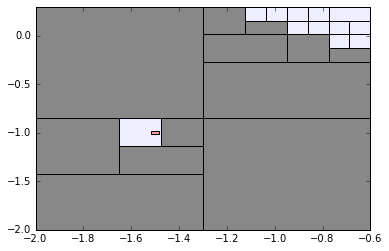

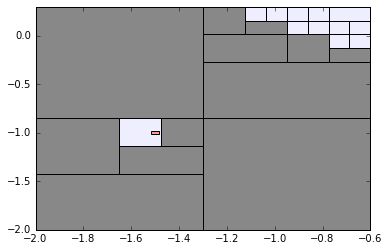

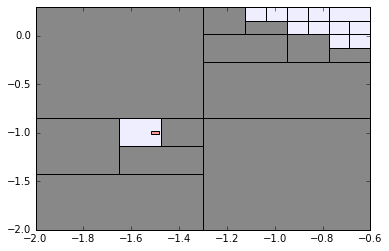

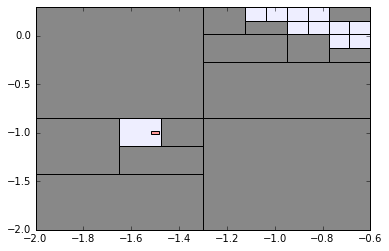

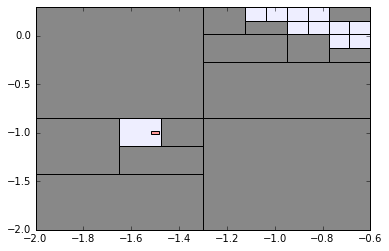

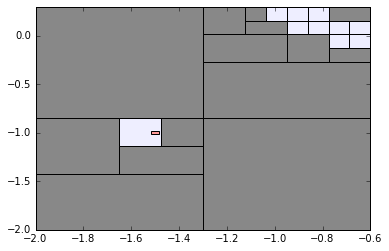

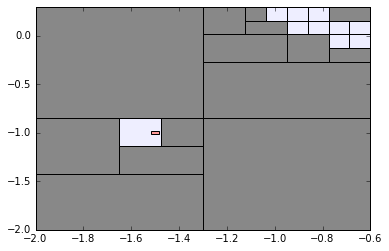

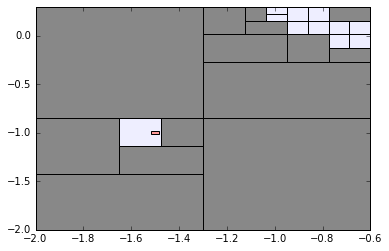

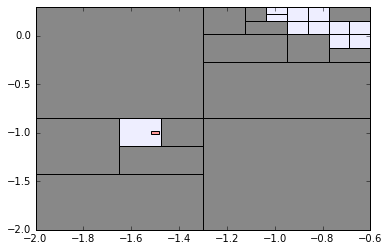

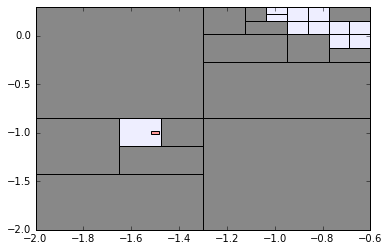

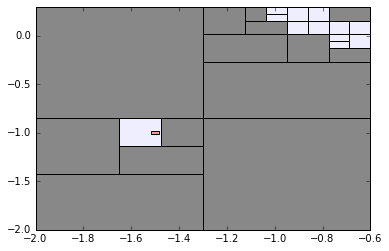

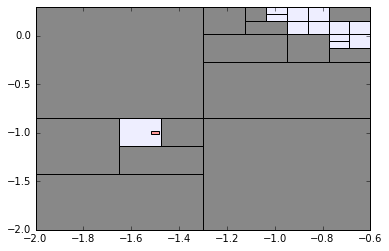

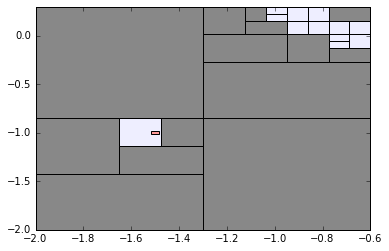

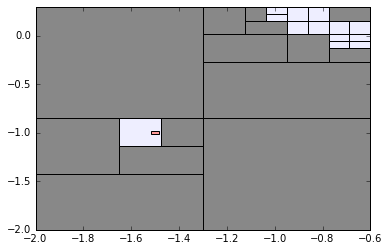

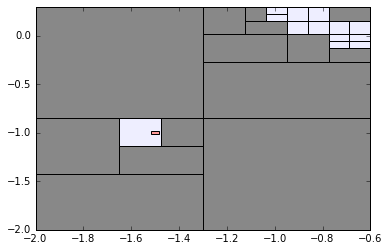

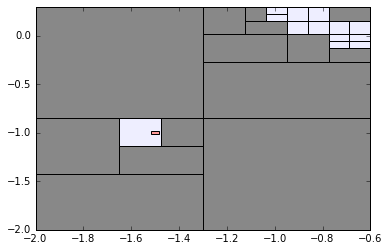

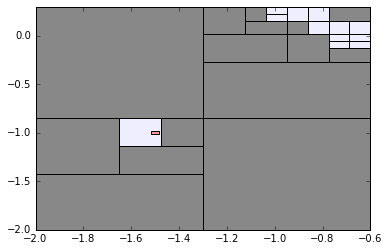

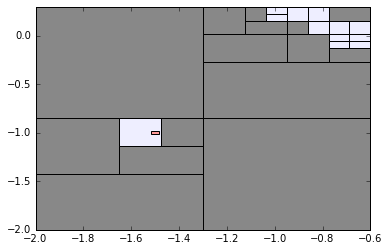

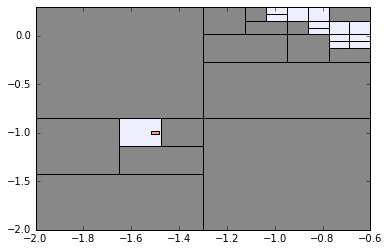

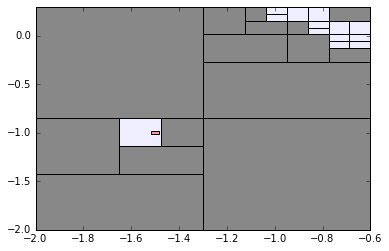

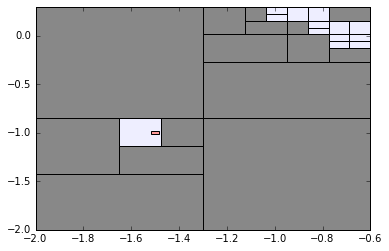

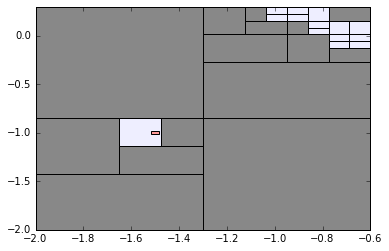

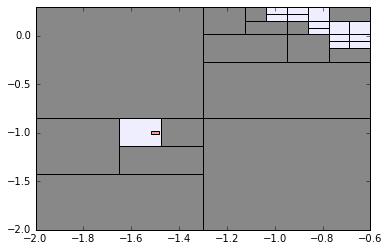

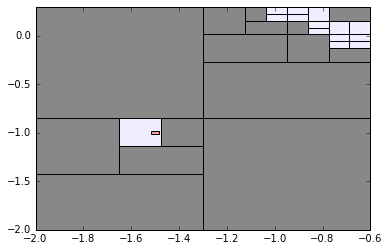

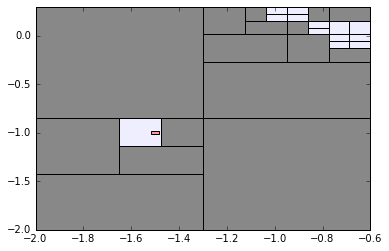

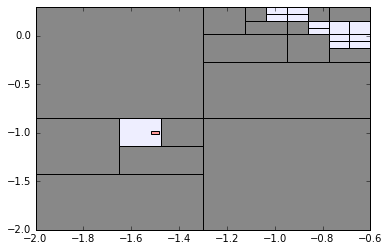

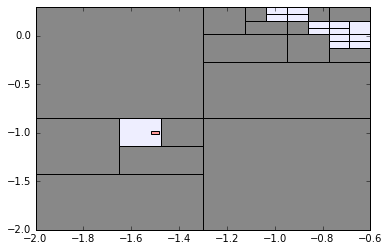

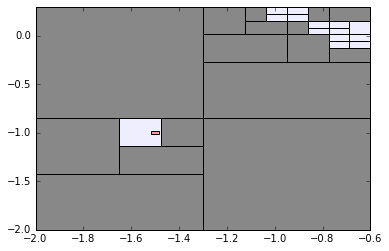

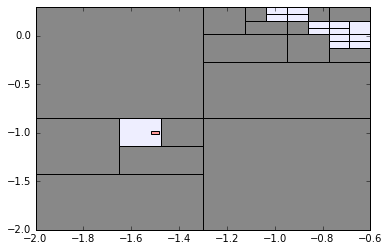

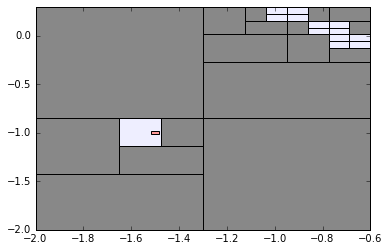

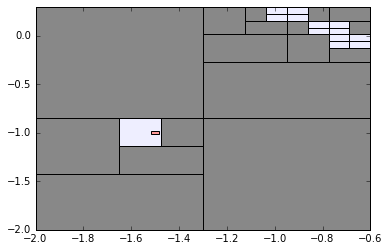

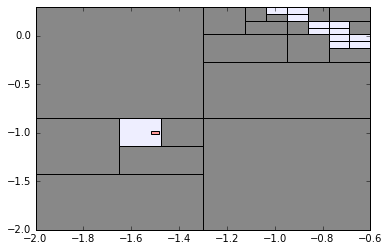

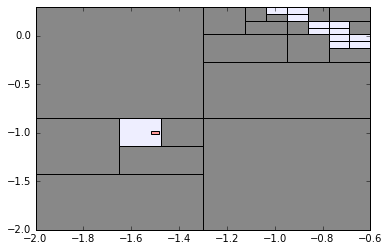

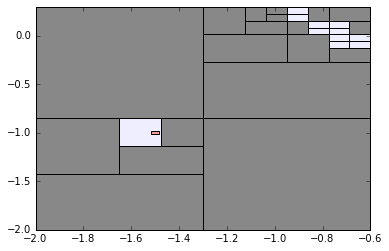

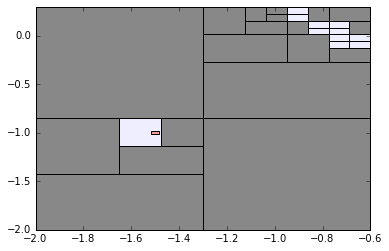

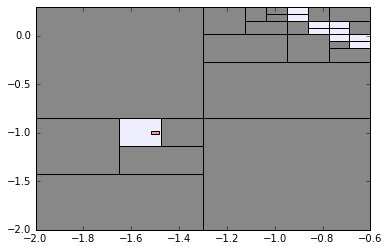

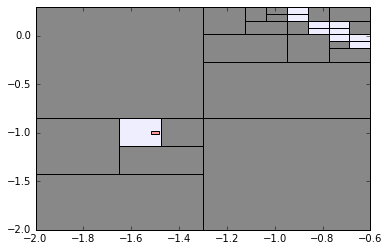

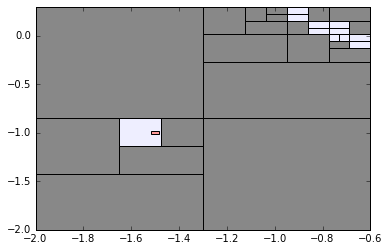

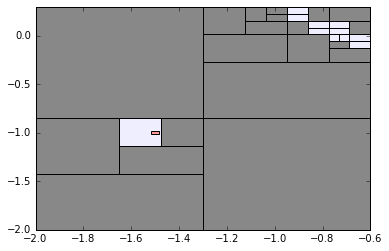

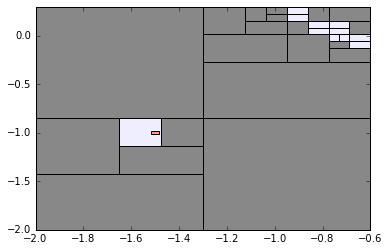

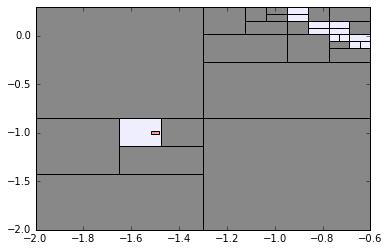

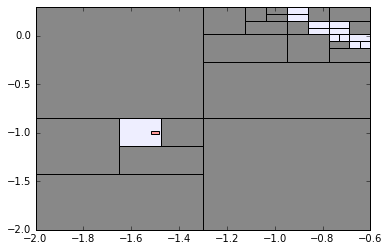

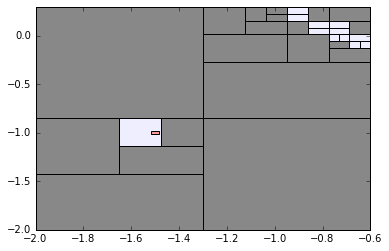

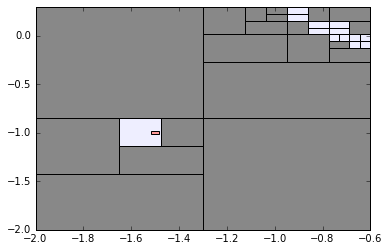

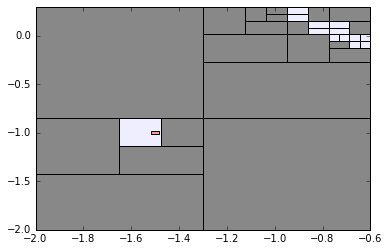

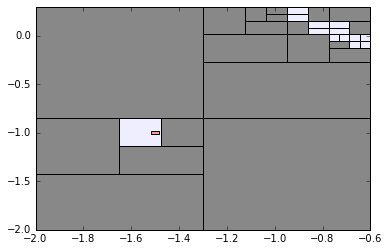

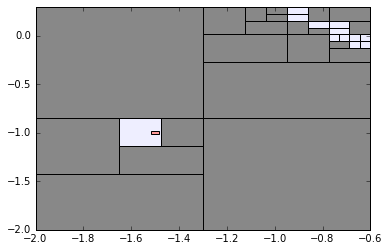

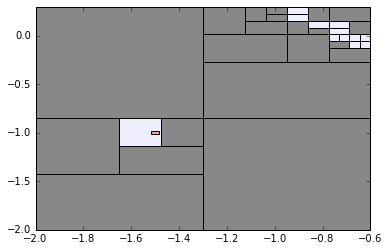

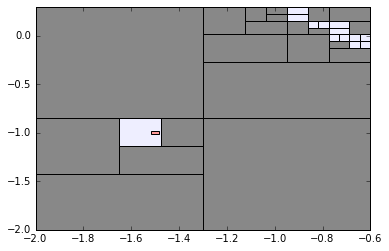

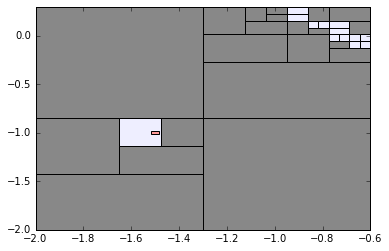

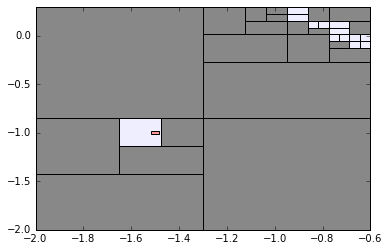

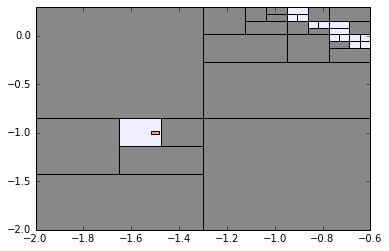

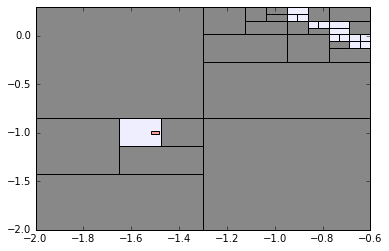

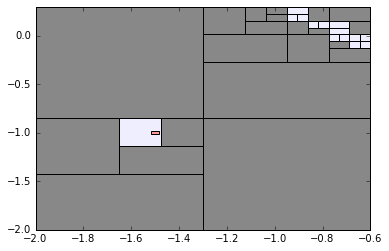

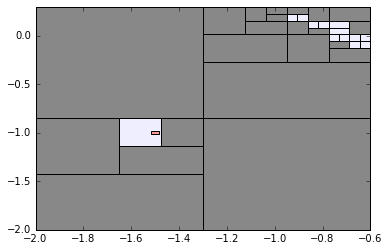

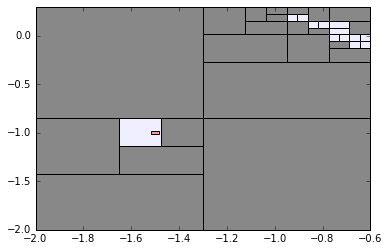

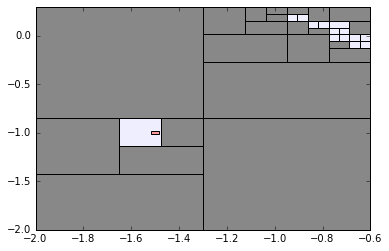

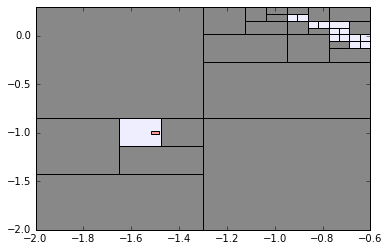

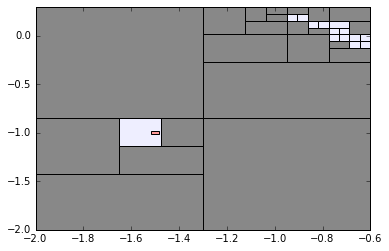

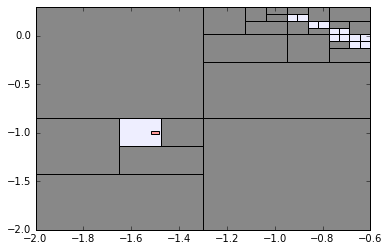

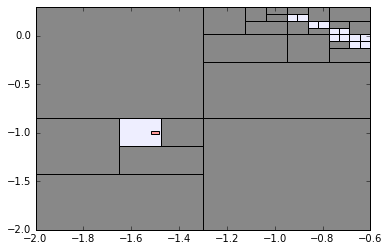

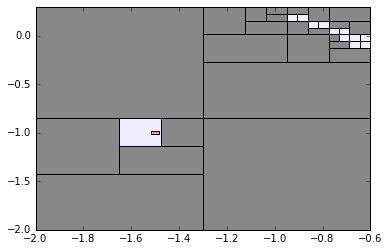

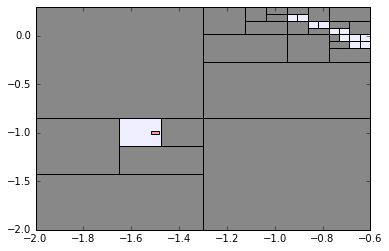

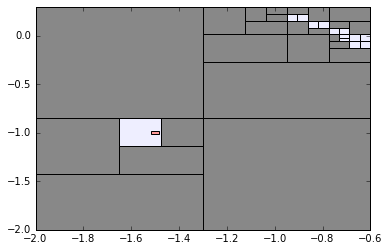

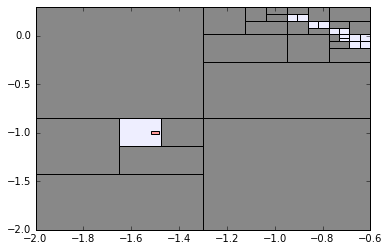

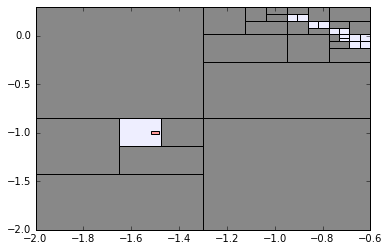

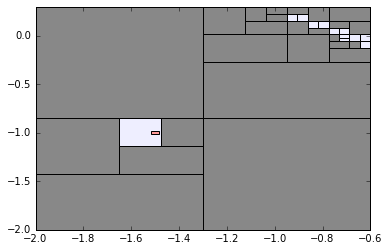

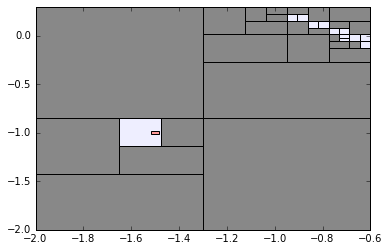

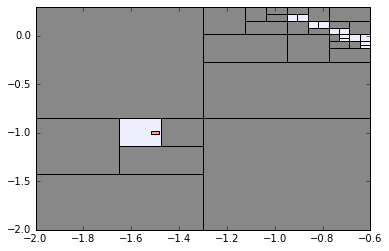

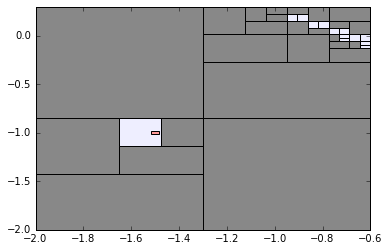

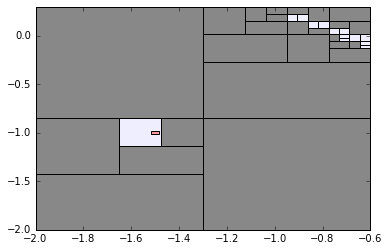

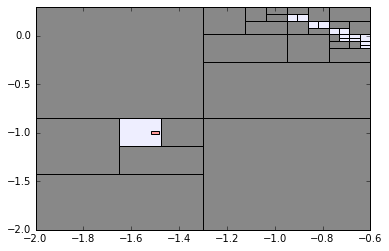

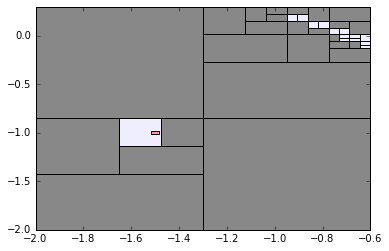

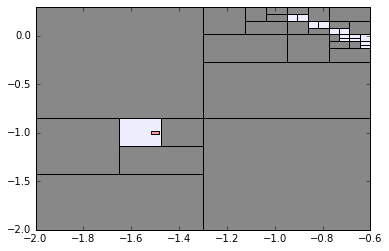

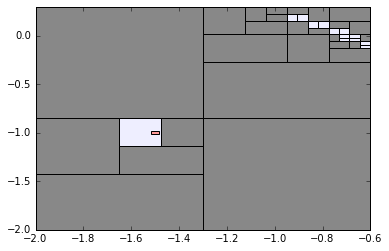

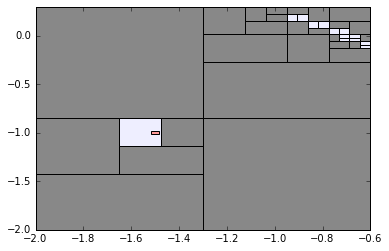

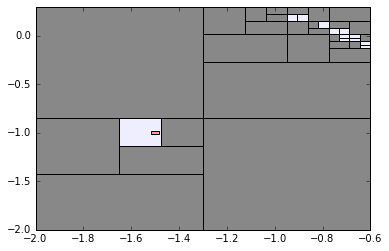

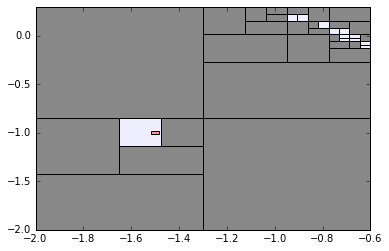

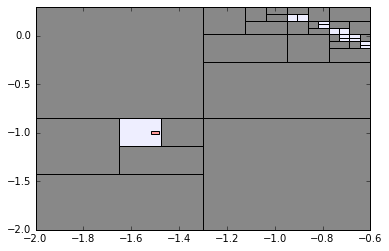

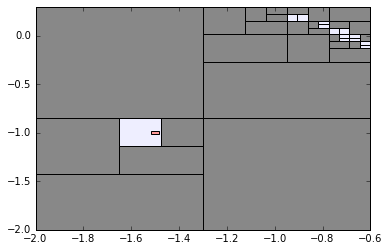

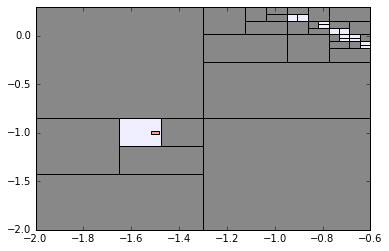

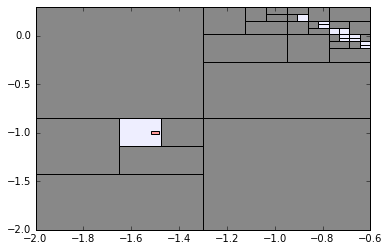

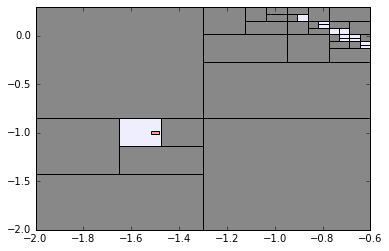

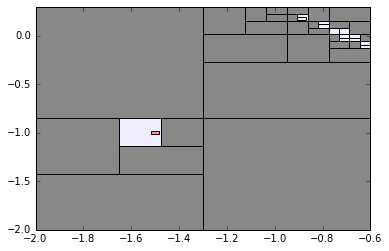

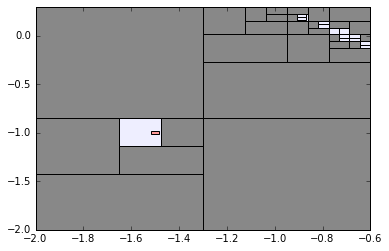

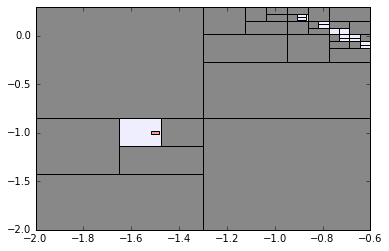

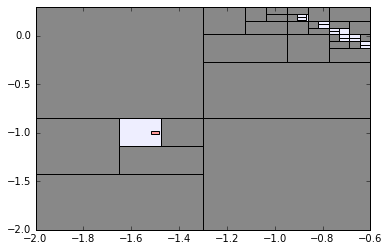

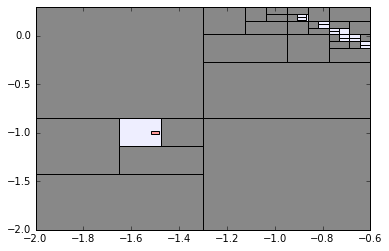

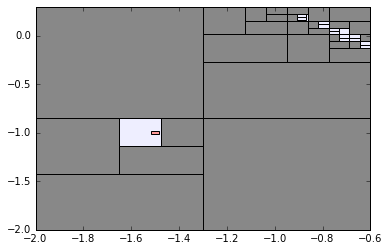

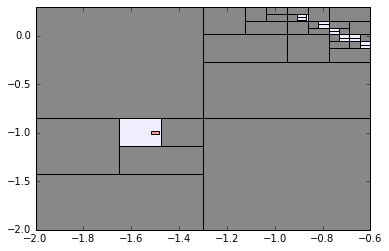

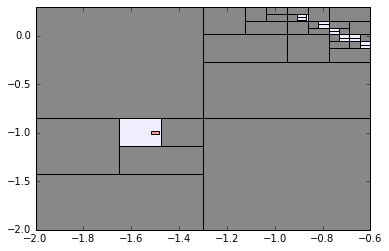

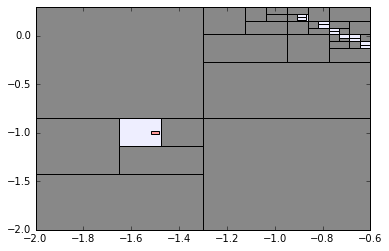

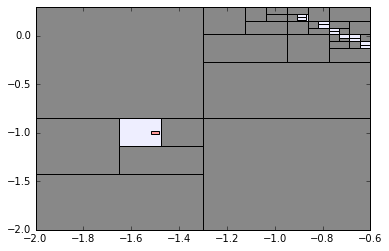

IndexError: tuple index out of range

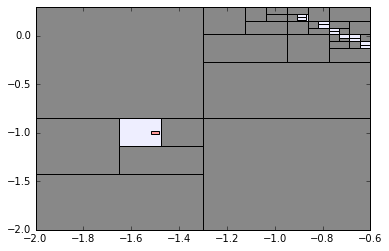

In [23]:
def get_rect(x_1, x_2, color_code):
    left, right, below, above = x_1[0][0], x_1[0][1], x_2[0][0], x_2[0][1]
    rect = Rectangle((left, below),
                    right - left,
                    above - below,
                    facecolor= color_code,
                    )
    return rect


x1_lim = animation_box[0][0][0][0][0]
x2_lim = animation_box[0][0][1][0][0]

ims = []
for i in range(len(animation_box)):
#    if i > 10: break
    fig = plt.figure()
    plt.xlim(x1_lim)
    plt.ylim(x2_lim)
    ax = fig.add_subplot(111)
    for j in range(i+1):
        parent_box, parent_flag = animation_box[j]
        color_code = flag_color_map[parent_flag]
        parent_x1 = parent_box[0][0]
        parent_x2 = parent_box[1][0]
        rect = get_rect(parent_x1, parent_x2, color_code)
        ax.add_patch(rect)
    plt.show()
    fig.savefig("anime_{0:0>4}.png".format(i))

## デモンストレーション

In [ ]:
x_1= interval[-1.6, -1.35]
x_2 = interval[-0.9,-1.16]

# x_1= interval[-1.6, -1.33]
# x_2 = interval[-0.96,-1.12]

In [ ]:
X = ivmat([[x_1],[x_2]])
kra = Krawczyk(f_grad,f_grad_grad,X)
print X
print '------ start ------'


for i in range(0,5+1):
    res = kra.refine(kra.X, i)
    print res
    fig = plt.figure()
    plt.xlim(*X[0][0][0])
    plt.ylim(*X[1][0][0])
    ax = fig.add_subplot(111)
    left,right,below,above = res[0][0][0][0],res[0][0][0][1],res[1][0][0][0],res[1][0][0][1]
#    print left,right,below,above
    rect = Rectangle((left, below),
                    right - left,
                    above - below,
                    facecolor="#079955",
                    alpha = 0.5
                    )
    ax.add_patch(rect)
    rect = Rectangle((left+0.02, below+0.02),
                    right - left,
                    above - below,
                    facecolor="#ff9955",
                    alpha = 0.5
                    )
    ax.add_patch(rect)
    plt.show()
    

In [ ]:
for i in range(0,5+1):
    res = kra.refine(kra.X, i)
    print res
    plt.figure()
    plt.xlim(*X[0][0][0])
    plt.ylim(*X[1][0][0])
    below,above,left,right = res[0][0][0][0],res[0][0][0][1],res[1][0][0][0],res[1][0][0][1]

    plt.axvspan(below, above, facecolor='r', alpha=0.4)
    plt.axhspan(left, right, facecolor='b', alpha=0.4)
    plt.show()

In [ ]:
a = ivmat([[interval[1,3]], [interval[2,7]]])
b = ivmat([[interval[-2,0.2]], [interval[1,4]]])

$ K(X) = m(X) - Y f(m(X)) + \{I - Y F^{'}(X)\}(X - m(X))$

where

$m(X) $is midpoint of $X$,

$Y$ is approximation of $m(F^{'}(X))^{-1}$
